In [1]:
from data_128 import *
from keras.models import load_model
from empatches import EMPatches
import numpy as np
from matplotlib import pyplot as plt
import os
import cv2
from img_prcs import *
from skimage.morphology import (erosion, dilation, opening, closing, disk)
import matplotlib as mpl

In [2]:
test_path="/Users/behnaz/NCADD/prediction_cell_neurite/img"
file_list = [f for f in os.listdir(test_path) if f[-3:]=="tif"][3]
print(file_list)
cell_model = load_model('DHM_Cell.hdf5')
neurite_model = load_model('DHM_Neurite.hdf5')

2022_08_09_D12_CS2_7_5X.tif
Metal device set to: Apple M1


In [3]:
img = img_read(test_path,file_list)
emp = EMPatches()
img_patches, indices = emp.extract_patches(img, patchsize=128, overlap=0.2) 

In [14]:
# Create a directory to save the image patches
output_dir = '/Users/behnaz/NCADD/prediction_cell_neurite/img_patches'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Loop over the image patches and save them to files
for i, patch in enumerate(img_patches):
    filename = os.path.join(output_dir, f'patch_{i}.png')
    cv2.imwrite(filename, patch)

In [4]:
np.shape(img_patches)

(64, 128, 128)

In [6]:
#Cell_prediction
NUM_TEST_IMAGES =len(img_patches)
testGene = testGenerators(img_patches)
c_results = cell_model.predict_generator(testGene,NUM_TEST_IMAGES,verbose=1)
cell_merged_img = emp.merge_patches(c_results, indices, mode='avg')

/var/folders/0c/_vv7vm4n5z33nmfk83_ct2480000gn/T/ipykernel_2050/1023370069.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  c_results = cell_model.predict_generator(testGene,NUM_TEST_IMAGES,verbose=1)
2023-05-23 12:34:34.159377: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


64/64 [==============================] - 3s 38ms/step


In [16]:
# Create a directory to save the image patches
output_dir = '/Users/behnaz/NCADD/prediction_cell_neurite/cell_patche'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Loop over the image patches and save them to files
for i, patch in enumerate(c_results):
    filename = os.path.join(output_dir, f'patch_{i}.tif')
    cv2.imwrite(filename, patch)

/var/folders/0c/_vv7vm4n5z33nmfk83_ct2480000gn/T/ipykernel_2077/4293430457.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  c_results = cell_model.predict_generator(testGene,NUM_TEST_IMAGES,verbose=1)


64/64 [==============================] - 3s 40ms/step


In [7]:
#Neurite_prediction
NUM_TEST_IMAGES =len(img_patches)
testGene = testGenerators(img_patches)
n_results = neurite_model.predict_generator(testGene,NUM_TEST_IMAGES,verbose=1)
neurite_merged_img = emp.merge_patches(n_results, indices, mode='min')

/var/folders/0c/_vv7vm4n5z33nmfk83_ct2480000gn/T/ipykernel_2050/4187782001.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  n_results = neurite_model.predict_generator(testGene,NUM_TEST_IMAGES,verbose=1)


64/64 [==============================] - 3s 38ms/step


In [ ]:
output_dir = '/Users/behnaz/NCADD/prediction_cell_neurite/neurite_patches'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Loop over the image patches and save them to files
for i, patch in enumerate(n_results):
    filename = os.path.join(output_dir, f'patch_{i}.tif')
    cv2.imwrite(filename, patch)

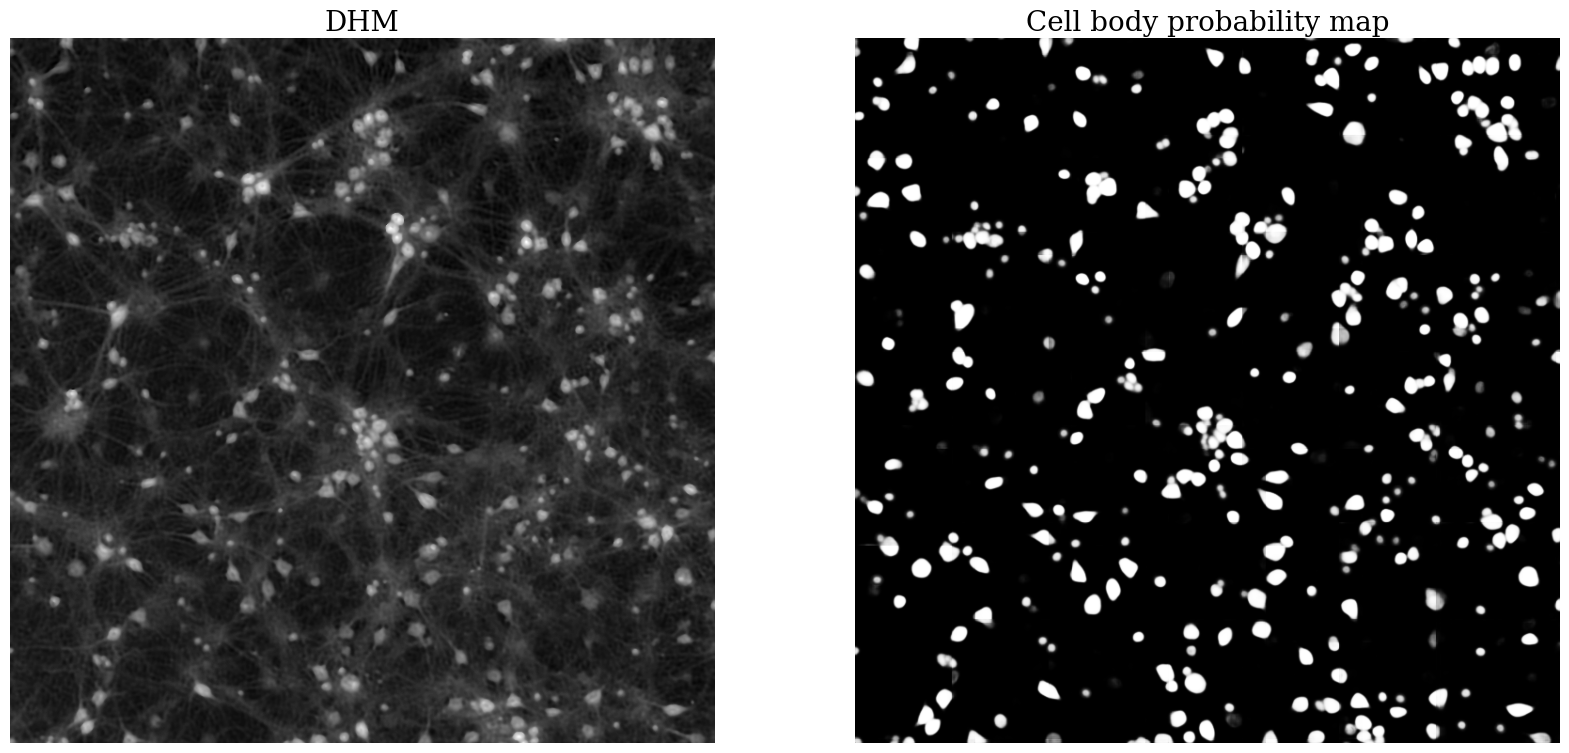

In [ ]:
#visualising srt mask

plot_comparison(img, cell_merged_img , 'DHM','Cell body probability map')
# plt.savefig('Cell_FOV2_Rat_4DIV.png')

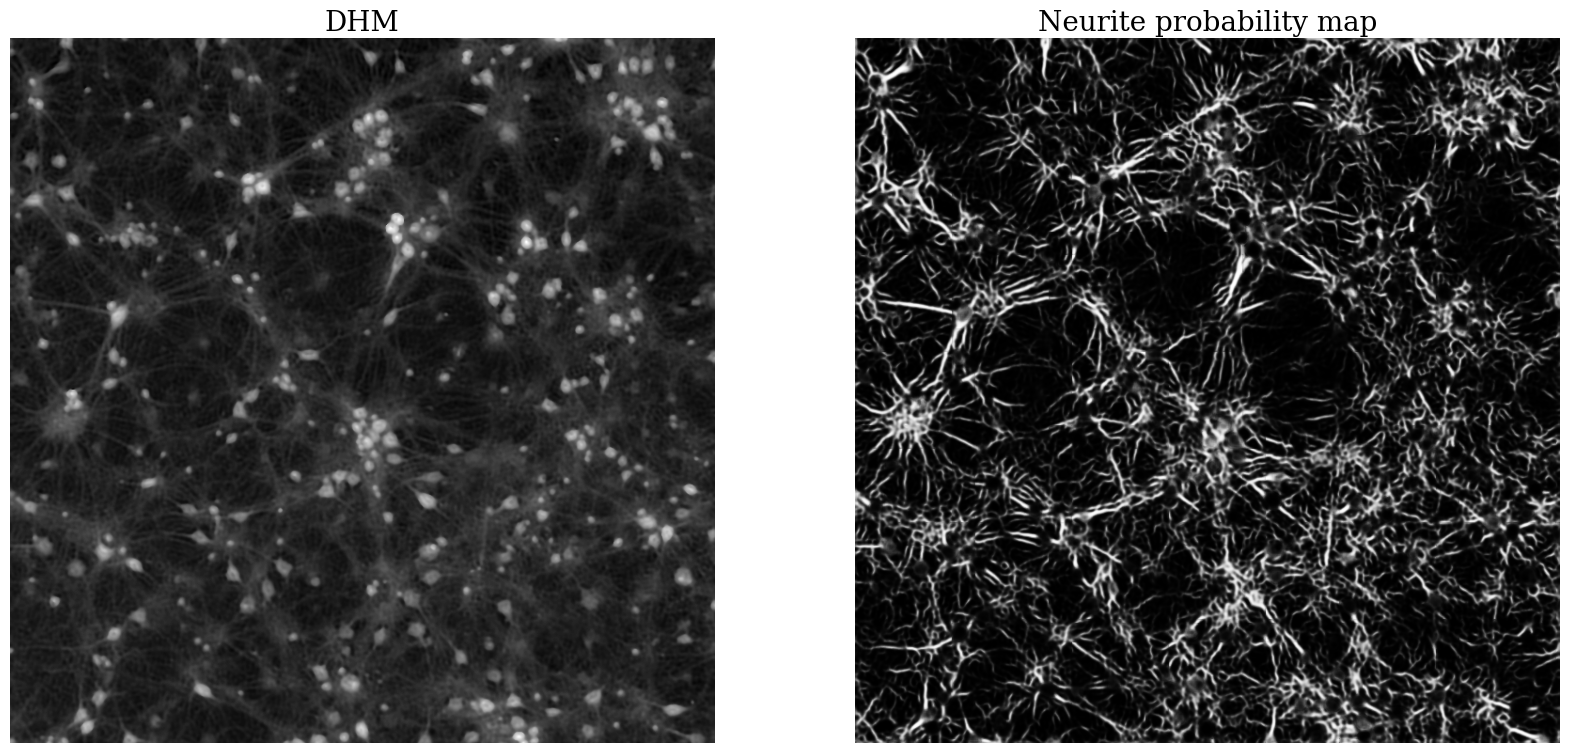

In [10]:
plot_comparison(img, neurite_merged_img, 'DHM','Neurite probability map')
# plt.savefig('Neurite_FOV2_Rat_4DIV.png')

In [21]:
np.shape(neurite_merged_img)

(750, 750, 1)

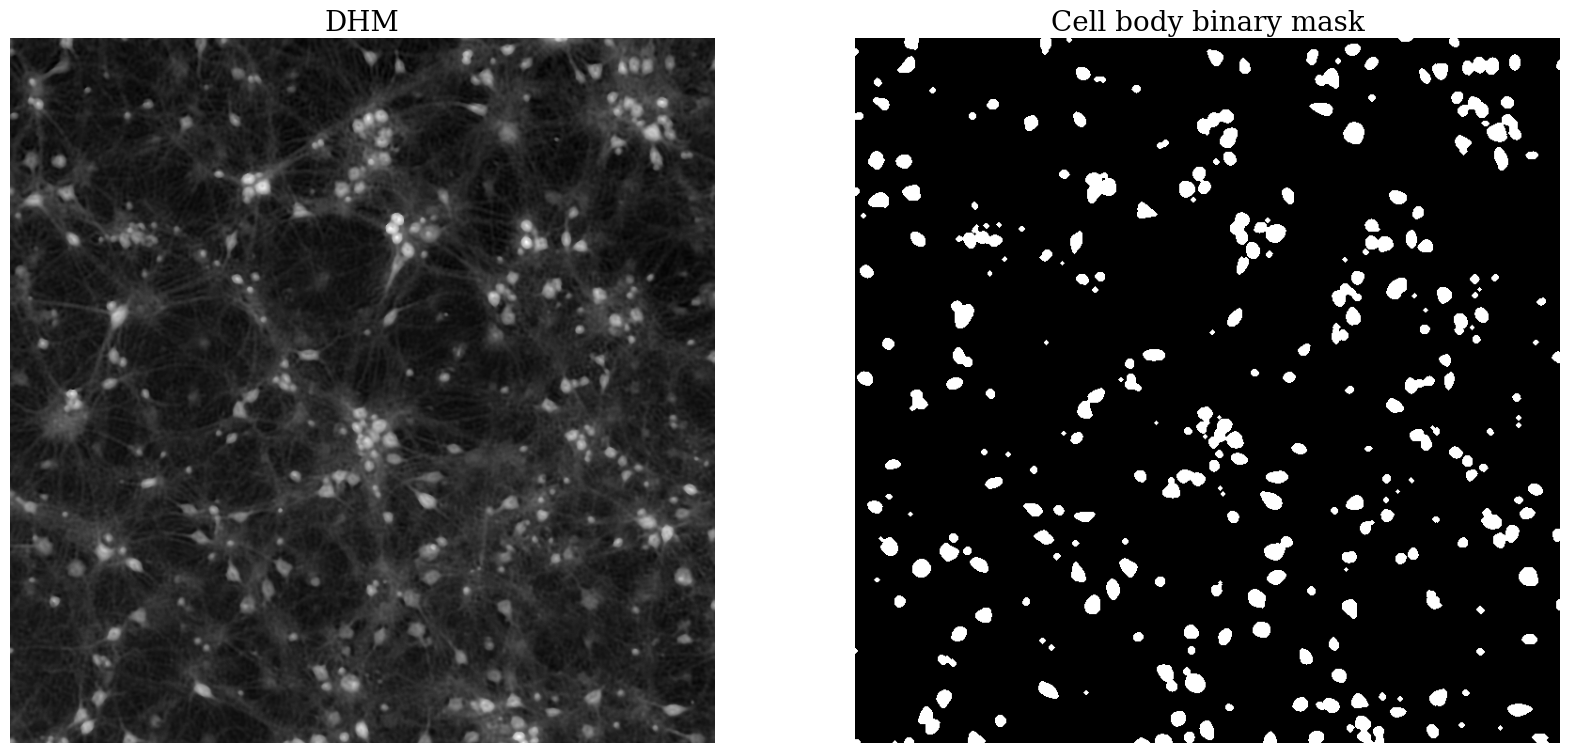

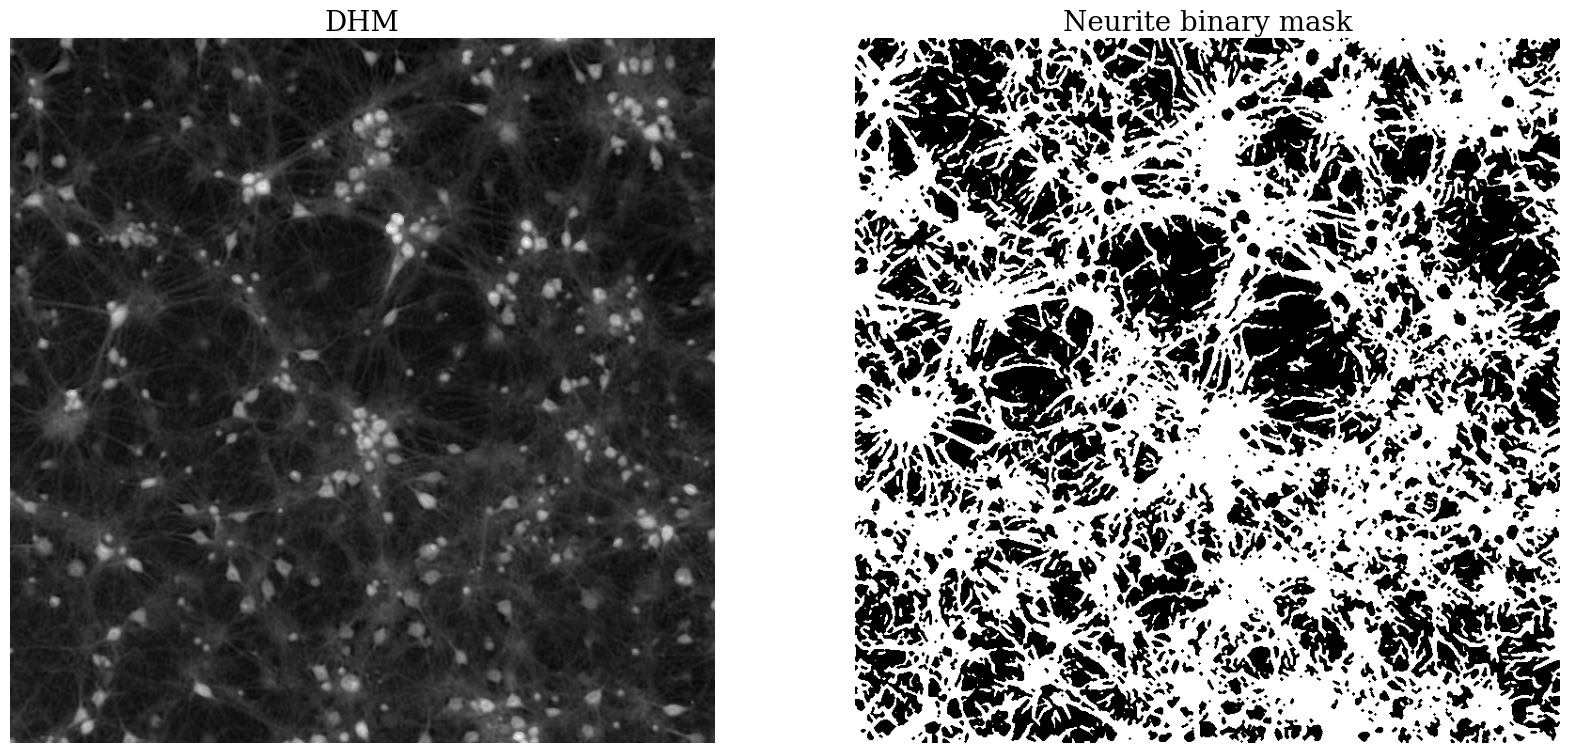

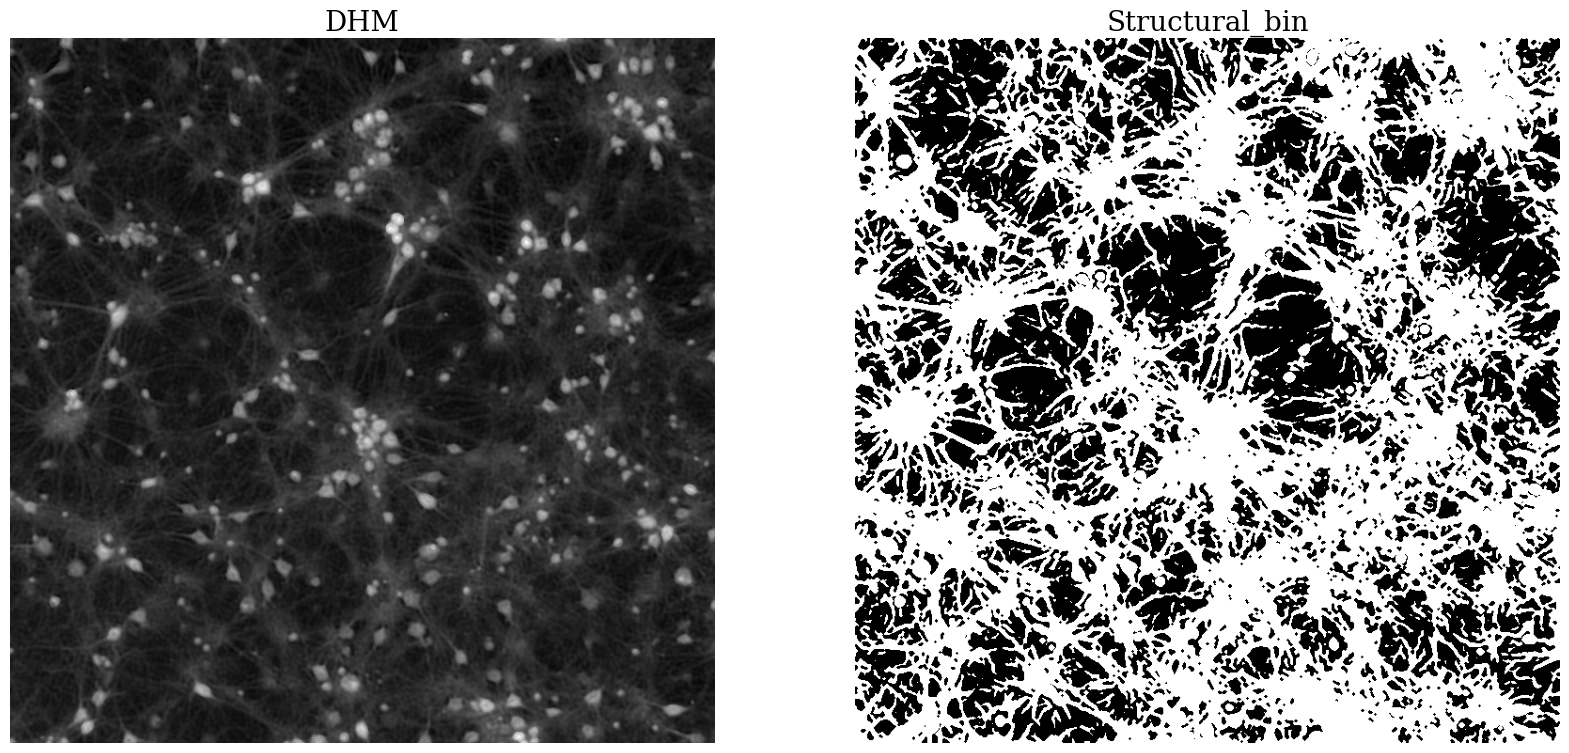

In [11]:
#visualising srt mask

Neurite = Neurite_Mask(neurite_merged_img)
Cell = Cell_Mask(cell_merged_img)
plot_comparison(img, Cell , 'DHM','Cell body binary mask')
#plt.savefig('cell.png')
plot_comparison(img, Neurite, 'DHM','Neurite binary mask')
#plt.savefig('neurite.png')
plot_comparison(img,(Cell+Neurite)>0,'DHM','Structural_bin')
#plt.savefig('cell+neurite.png')

305


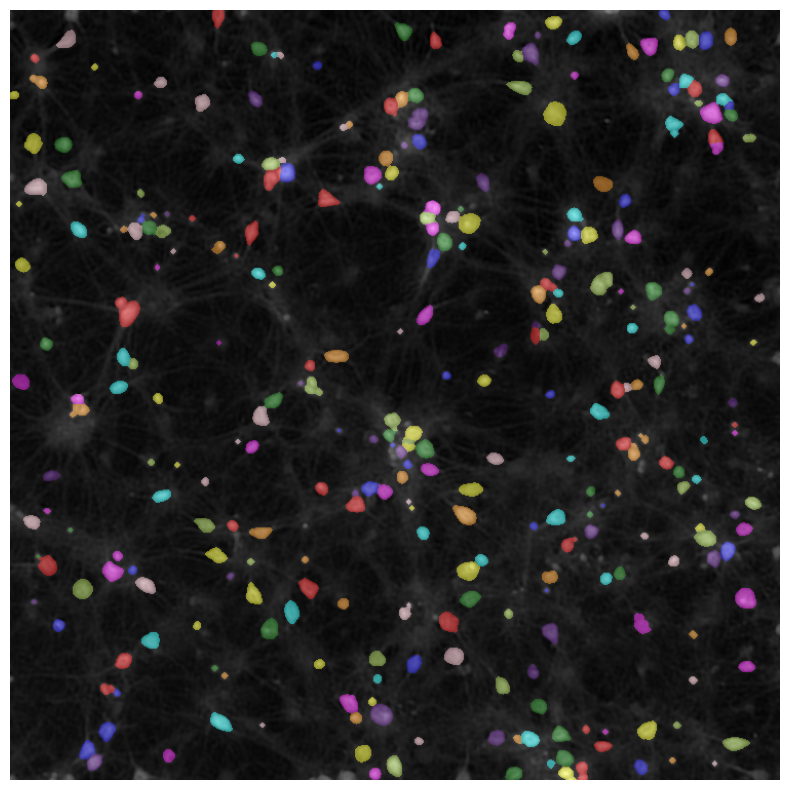

In [12]:
# Cell separation
font2 = {'family':'serif','color':'black','size':20}
Cell_watershed = wtr_shed(Cell)
color_labels = color.label2rgb(Cell_watershed, img, alpha=0.4, bg_label=0)
print(Cell_watershed.max())
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(color_labels, cmap = 'Greys')
plt.axis('off')
#ax.set_title('Segmentation result over raw image. Number of Cells = %i'%((Cell_watershed.max())),fontdict = font2)
#plt.savefig('watershed.png',dpi=300)
plt.show()

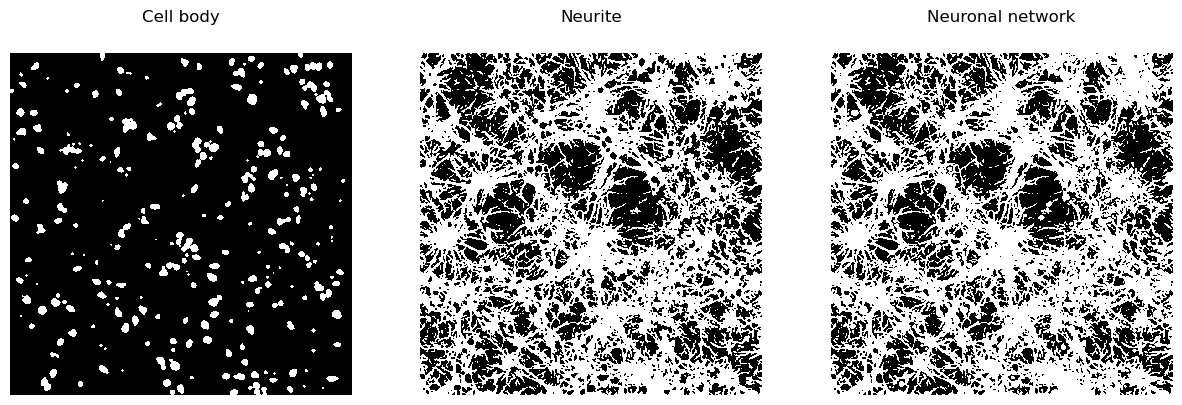

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))         
axs[0].matshow(Cell_watershed>0, cmap = 'Greys_r')
axs[0].axis('off')
axs[0].set_title('Cell body')
axs[1].matshow(Neurite, cmap = 'Greys_r')
axs[1].axis('off')
axs[1].set_title('Neurite')
axs[2].matshow((Cell_watershed+Neurite)>0, cmap = 'Greys_r')
axs[2].axis('off')
axs[2].set_title('Neuronal network')
plt.show()

In [15]:
total = 2*(Cell_watershed>0)+Neurite
total[total>1]=2
np.unique(total)

array([0, 1, 2])

(-0.5, 749.5, 749.5, -0.5)

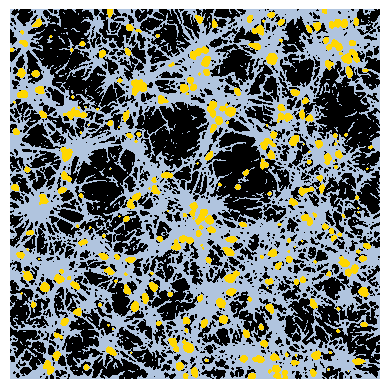

In [16]:
cmap = mpl.colors.ListedColormap(['black', 'lightsteelblue','gold'])
plt.imshow(total,cmap=cmap)
plt.axis('off')
#plt.savefig('3colormask.svg')
#plt.colorbar()